In [85]:
! sudo pip install scikit-video

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dropout
from keras import backend as K
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import models
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from google.colab import drive
from zipfile import ZipFile
from skimage.transform import resize
import skvideo.io

In [ ]:
drive.mount('/content/drive/', force_remount=True)
# file_path = '/content/drive/MyDrive/NUSFPID_FirstPerson_dataset.zip'
# with ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/data')

Mounted at /content/drive/


In [86]:
def make_data():
  data_dir = '/content/drive/MyDrive/data/NUSFPID_FirstPerson_dataset'
  categories = ['cell', 'door', 'pass', 'shake', 'throw', 'type', 'wave', 'write']
# LOAD BASE MODEL FROM RESNET50 AND USE IT FOR FEATURE EXTRACTION
  base_model = ResNet50(weights='imagenet')
  model_ex = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)
# LAYER'S OUTPUT SIZE = (100532)
  img_size = (100352,)
  pool_max = np.empty(img_size)
  pool_mean = np.empty(img_size)
  feature_arr = []
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []
# READ VIDEOS FROM EACH FOLDER AS CLASS
  for label in categories:
    path = os.path.join(data_dir, label)      
    class_num = categories.index(label)
    class_num = np_utils.to_categorical(class_num, 8)
    
    feature = []
    # READ & CONVERT EACH VIDEO TO AN IMAGE ARRAY
    for video in os.listdir(path):
      pool_max = np.zeros(img_size)
      pool_mean = np.zeros(img_size)
      # CONVERT VIDEO TO FRAMES WITH SIZE (224,224,3)
      video_data = skvideo.io.vread(os.path.join(path,video), height=224, width=224)
      for fr in video_data:
        fr = np.expand_dims(fr, axis=0)
        # FAETURE EXTRACTION FOR EACH FRAME
        fp = model_ex.predict(fr)
        # MAX & MEAN POOLING FOR EACH VIDEO
        frame = fp.flatten()
        # pool_max = np.maximum(frame, pool_max)
        df = pd.DataFrame([[frame],[pool_mean]]) 
        pool_mean = np.mean(df[0])
      feature.append(pool_mean)
      # feature.append(pool_max)
      print(len(feature))
    # PREPARE DESIERDE OUTPUT
    y_tr = [class_num]*len(feature)
    x_train, x_test, y_train, y_test = train_test_split(feature, y_tr, test_size=0.5)
    X_train.extend(x_train)
    Y_train.extend(y_train)
    X_test.extend(x_test)
    Y_test.extend(y_test)

    del feature
  return X_train, Y_train, X_test, Y_test


In [ ]:
X_tr, Y_train, X_ts, Y_test = make_data()

In [89]:
X_train = np.array(X_tr).astype('float32')/255
X_test = np.array(X_ts).astype('float32')/255
Y_train = np.array(Y_train).astype('float32')/255
Y_test = np.array(Y_test).astype('float32')/255


3/3 [==============================] - 0s 13ms/step - loss: 324.8393 - accuracy: 0.1282

 Test accuracy: 0.12820513546466827


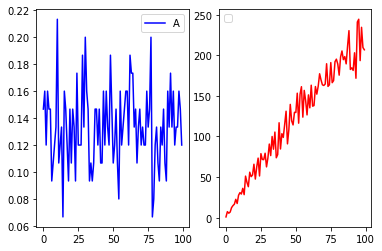

In [98]:
# FULLY CONNECTED LAYER FOR MODEL
model = Sequential()

model.add(Flatten())
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.6)

history =  model.fit(X_train, Y_train, epochs=100,  verbose=0)
# PLOT ACCURACY & LOSS
fig ,(p1, p2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False)
p1.plot(history.history['accuracy'], color='blue', label='accuracy')
p1.legend('Accuracy')
p2.legend('Loss')
p2.plot(history.history['loss'], color='red', label='loss')
fig.show

score = model.evaluate(X_test, Y_test)
print('\n', 'Test accuracy:', score[1])

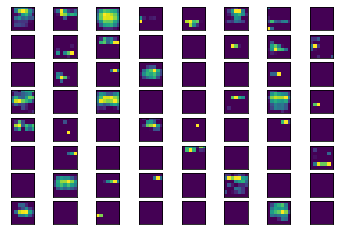

In [ ]:
def plot_feature():
  base_model = ResNet50(weights='imagenet')
  model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

  video_data = skvideo.io.vread("/content/drive/MyDrive/data/NUSFPID_FirstPerson_dataset/cell/01.mp4", height=224, width=224)  

  x = video_data[200,:,:,:]
  x = image.img_to_array(x)
  x = np.expand_dims(x, axis=0)
  features = model.predict(x)

  square = 8
  ix = 1
  for _ in range(square):
    for _ in range(square):
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(features[0, :, :, ix-1])
      ix += 1
  plt.show()

plot_feature()